# MuVi experiments
Based on [paper](https://arxiv.org/abs/2204.06242). We have B Cells data with different interventions. In this notebook we use MuVi to compute grouped factors for synthetic data simulatinng control and different interventions.

# Simulated data
We'll simulate data of the form 
$$ Y = \begin{pmatrix}
Y^{(1)}&\mathbf{0}_n\\
Y^{(2)}&\mathbf{1}_n\end{pmatrix}$$

where $Y^{(1)} \sim N(0,\sigma_1^2I_n), Y^{(2)} \sim N(\Delta,\sigma_2^2 I_n)$, and the last column is the dummy variable indicating whether samples received treatment or not. Let us assume $\sigma_1=\sigma_2$ and $n$ at first. 

This emulates the scenario of $Y$ the normalized matrix of cells $\times$ genes with **covariates**, with the $Y^{(1)}$ are the control cells and $Y^{(2)}$ are treatment.

# MuVi recap: single-view with covariates
Recall we're modelling the $i$ row of $Y$ as 
$$y_i \sim N(Wx_i,\Psi)$$
where the latent variables are $x_i\sim N(0,I)$, $\Psi$ is diagonal, and
$$w_{j,k} \sim N(0,(\tau\delta_k\lambda_{j,k})^2),$$
are the factor loadings, where $\tau$ is a global shrinking factor, $\delta_k$ measures the importance of the $k$-th factor and $\lambda_{j,k}^{(m)}$ measures and element wise importance. Note that MuVi further regularizes the shriking factors, effectively capping the max variance to $c_{j,k}$, an inverse gamma r.v.

## Covariates in MuVi
To incorporate covariate $Z$, we change the structure of (2) to:
$$
\begin{split}
y_i&\sim N(\mu_i,\Psi)\\
\mu_i&= Wx_i + \beta_iZ_i
\end{split}
$$
where $\beta_i\sim N(0,1)$.


# Methods in simultated data
We ran 9 experiments. We compute the factors for all the combinations of
1. Without covariates and with covariates:
    1. This is to test how well do the $\beta_i Z_i$ capture the labeling. This $\beta_i Z_i$ acts as a regression / classification using the covariates on Y
    1. We expect the reconstruction (MSE) to stay the same
    1. We expect for $Wx$ to capture the shared trend with and without, 
    1. and for the variance explained to increase with covariates
2. Different true latent dimensions: 
    1. This is to test how well are the correlated factors capturing the signal
    1. We simulate data from true latent dimension $N$ by generating $Y = [Y_i]_{i=1}^N$
    1. When plotting Variance Explained vs Num Factors, we expect (both in PCA and in MuVi) for the $N+1,...$ factors to explain little to no additional variance
3. Add trend common to control and treatment
    1. We expect for $\beta_iZ$ to capture nothing about the trend, should only be captured by $Wx$. This $Wx$ acts as a factorization on the residuals of the $b_i Z_i$ regression.
    
# Results
\loremipsum

# Set up and Data Loading

In [1]:
import muvi

import logging

# Disable all logging messages
logging.disable(logging.CRITICAL)

/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import anndata as ad
import numpy as np
from scipy.io import mmread
from sklearn.metrics import root_mean_squared_error
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
    print(device)
except Exception as e:
    print(e)

cuda:0


In [4]:
SIGMA = 1 # TODO: change sigma per cluster
def generate_data(size,taus):
    """
    generate matrix with concatenation of [N(tau,sigma) for tau in tau] for given size
    """
    cells,genes = size
    fn = np.random.normal # change to other distribution
    data = []
    for tau in taus:
        data.append(fn(loc=tau,scale = SIGMA,size=(cells,genes)))
    data = np.concatenate(data,axis = 0)
    # create labels TODO: one-hot encode them
    labels = np.repeat(np.arange(len(taus)), cells)
    return data,labels

def addlabels(x,y):
    """
    function to add value labels in barplot
    """
    decimals = 3
    for i in range(len(x)):
        plt.text(i, round(y[i],decimals)+0.01, round(y[i],decimals), ha = 'center')
        
def generate_centers(n,genes,a=0,b=1):
    """
    generate 1 center at zero and n-1 uniform[a,b]
    """
    return [np.zeros(shape = (1,genes))]+list(np.random.uniform(low=a, high=b,size=(n-1,genes)))
generate_centers(n=2,genes=2,a=0,b=1)

[array([[0., 0.]]), array([0.9523549 , 0.99775329])]

# Factors with simulated data wo covariates

**TODOs**:
1. should these be log-poissons??
2. compute reconstruction MSE

## Two factors

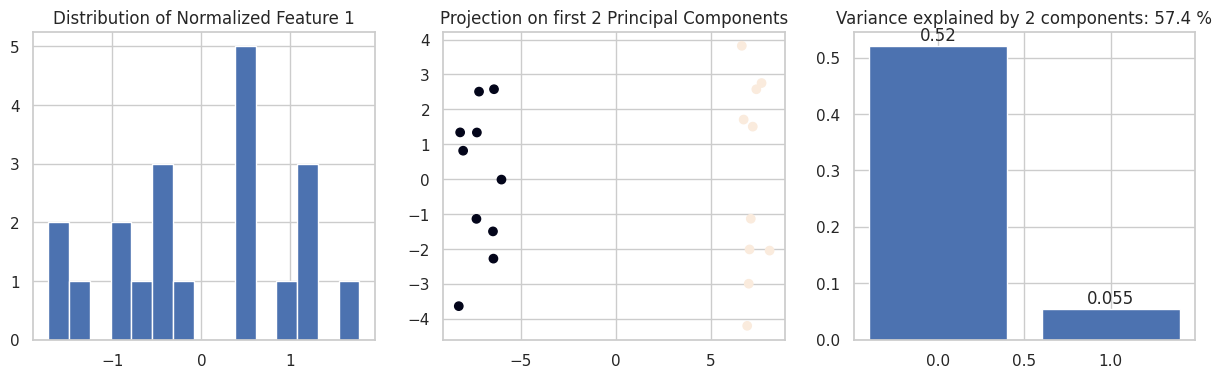

In [5]:
# define centers of normals
cells,genes = (10,100)
taus = generate_centers(n=2,genes=genes,a=0,b=5)
# generate data
y,labels = generate_data(size=(cells,genes), taus = taus)
mu,sd = y.mean(axis=0), y.std(axis=0)
# normalize
y = (y-mu)/sd
# visualize first column of data. Should look like N normals
fig,ax = plt.subplots(1,3,figsize=(15,4))
i = 0
ax[0].hist(y[:,i],bins=15)
ax[0].set_title(f'Distribution of Normalized Feature {i+1}')
# plt.show()
# compute PCA
n_components = len(taus)
pca = PCA(n_components=n_components)
y_proj = pca.fit_transform(y)
# plot data on first 2 components
ax[1].scatter(y_proj[:,0],y_proj[:,1],c = labels)
ax[1].set_title('Projection on first 2 Principal Components')
# plt.show()
# Compute % of var explained
ax[2].bar(x = np.arange(n_components),height = pca.explained_variance_ratio_)
addlabels(x=np.arange(n_components),y=pca.explained_variance_ratio_)
ax[2].set_title(f'Variance explained by {n_components} components: {round(100*sum(pca.explained_variance_ratio_),1)} %')
plt.show()

In [26]:
model = muvi.MuVI(
    observations={"dna": y}, # single view
    n_factors=n_components,
    device=device,
    prior_confidence='low',
    normalize=False
)
max_iter = 1000
model.fit(seed=0,n_epochs=max_iter)
factor_scales = model._guide.get_factor_scale() # delta of factor k
factor_scales = factor_scales / np.max(factor_scales, axis=1)[:, None]
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and gene j
approx_ws = np.concatenate(approx_ws, axis=1)
approx_x = model.get_factor_scores() # factor k in cell i

 35%|███▍      | 348/1000 [00:07<00:14, 43.80it/s, ELBO=144]

Relative improvement of -3.309e-05 < 1e-05 for 10 step(s) in a row, stopping early.


/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


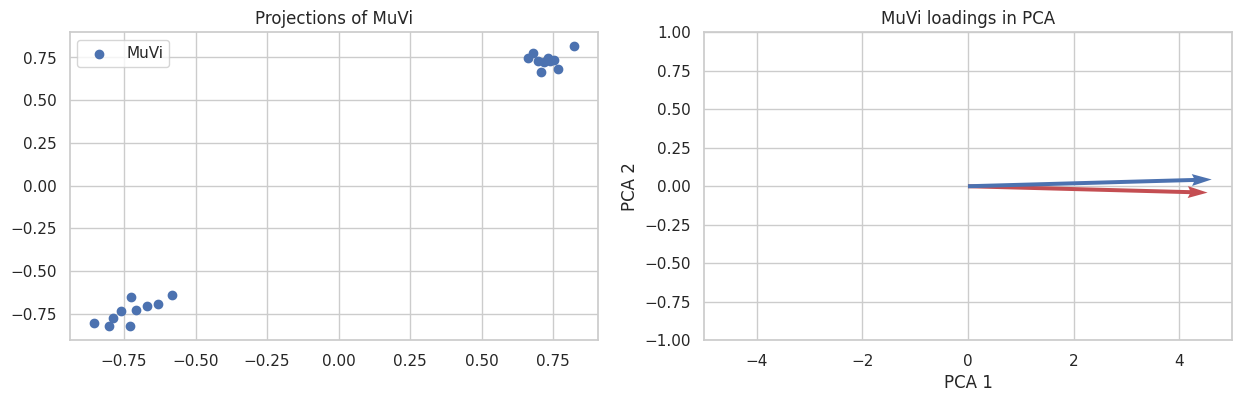

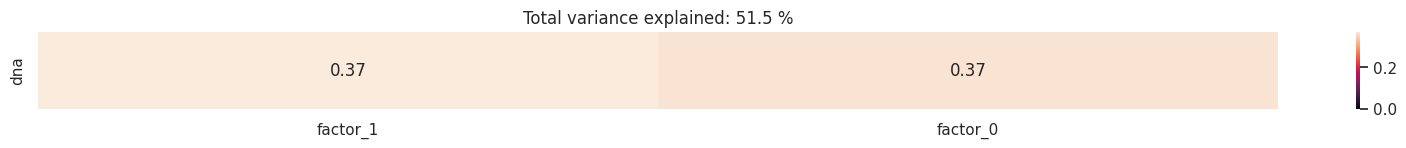

In [27]:
# visualize MuVi factors
fig,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].scatter(approx_x[:,0],approx_x[:,1],label='MuVi')
# plot data on first 2 components
ax[0].legend()
ax[0].set_title('Projections of MuVi')

# project MuVi loadings into PCAs
muvi_in_pcas = pca.transform(approx_ws)
ax[1].quiver([0, 0], [0, 0], muvi_in_pcas[:, 0], muvi_in_pcas[:, 1], angles='xy', scale_units='xy', scale=1, color=['r', 'b'])
# # Set limits for better visualization
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-1, 1)
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 2')
ax[1].set_title('MuVi loadings in PCA')

# plot variance explained
r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
g = muvi.pl.variance_explained(model,annot=True,show=False)
plt.title(f"Total variance explained: {round(100*r2_view['dna'],1)} %")
plt.show()

## De-couple factors with Masking 
Recall the mask induces certain gene-gene relationships. We don't have a prior so we'll test arbitrary ones to try to de-couple the factors.

In [50]:
def generate_mask_2_trig(genes):
    mask_0 = np.ones(shape=(2,genes//2))
    mask_1 = np.concatenate([np.ones(shape=(1,genes//2)),np.zeros(shape=(1,genes//2))],axis=0)
    return np.concatenate([mask_0,mask_1],axis=1)

generate_mask_2_trig(4)

array([[1., 1., 1., 1.],
       [1., 1., 0., 0.]])

 38%|███▊      | 376/1000 [00:09<00:15, 40.74it/s, ELBO=145]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.0001653 < 1e-05 for 10 step(s) in a row, stopping early.


 38%|███▊      | 376/1000 [00:09<00:15, 41.17it/s, ELBO=144]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -2.836e-05 < 1e-05 for 10 step(s) in a row, stopping early.


 35%|███▍      | 348/1000 [00:08<00:16, 40.68it/s, ELBO=144]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.00021 < 1e-05 for 10 step(s) in a row, stopping early.


 35%|███▍      | 348/1000 [00:08<00:15, 41.38it/s, ELBO=143]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.0007378 < 1e-05 for 10 step(s) in a row, stopping early.


 64%|██████▍   | 639/1000 [00:15<00:08, 40.43it/s, ELBO=143]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.0001772 < 1e-05 for 10 step(s) in a row, stopping early.


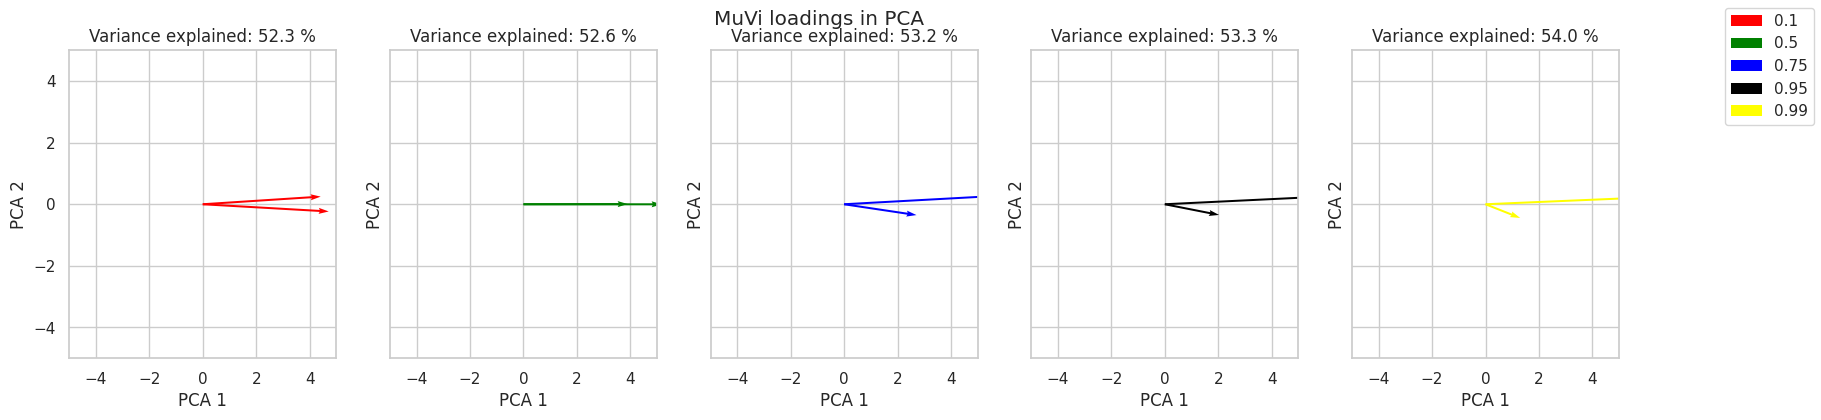

In [46]:
prior_confidence = [0.1,0.5,0.75,0.95,0.99]
fig,ax = plt.subplots(1,len(prior_confidence),figsize=(20,4),sharey=True)
c = ['red','green','blue','black','yellow','purple']
for i,p in enumerate(prior_confidence):
    model = muvi.MuVI(
        observations={"dna": y}, # single view
        # n_factors=n_components,
        device=device,
        prior_confidence=p,
        normalize=False,
        prior_masks={'dna':generate_mask_2_trig(genes)}
    )
    max_iter = 1000
    model.fit(seed=0,n_epochs=max_iter)
    approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and gene j
    approx_ws = np.concatenate(approx_ws, axis=1)
    # project MuVi loadings into PCAs
    muvi_in_pcas = pca.transform(approx_ws)
    ax[i].quiver([0, 0], [0, 0], muvi_in_pcas[:, 0], muvi_in_pcas[:, 1], angles='xy', scale_units='xy', scale=1, label=f'{p}', color = c[i%len(prior_confidence)])
    # # Set limits for better visualization
    ax[i].set_xlim(-5, 5)
    ax[i].set_ylim(-5, 5)
    ax[i].set_xlabel('PCA 1')
    ax[i].set_ylabel('PCA 2')
    r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
    ax[i].set_title(f"Variance explained: {round(100*r2_view['dna'],1)} %")

fig.suptitle('MuVi loadings in PCA')
fig.legend()
plt.show()

**Observations**
1. One factor (the unmasked) absorbes all and explodes
2. They seem to de-couple and the var explained increases

In [49]:
def generate_mask_2_diag(genes):
    mask_0 = np.concatenate([np.ones(shape=(1,genes//2)),np.zeros(shape=(1,genes//2))],axis=0)
    mask_1 = np.concatenate([np.zeros(shape=(1,genes//2)),np.ones(shape=(1,genes//2))],axis=0)
    return np.concatenate([mask_0,mask_1],axis=1)

generate_mask_2_diag(4)

array([[1., 1., 0., 0.],
       [0., 0., 1., 1.]])

 38%|███▊      | 376/1000 [00:09<00:15, 40.96it/s, ELBO=145]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.0001302 < 1e-05 for 10 step(s) in a row, stopping early.


 42%|████▏     | 422/1000 [00:10<00:13, 41.59it/s, ELBO=142]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.001615 < 1e-05 for 10 step(s) in a row, stopping early.


 38%|███▊      | 376/1000 [00:09<00:15, 41.22it/s, ELBO=143]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.0002769 < 1e-05 for 10 step(s) in a row, stopping early.


 42%|████▏     | 422/1000 [00:10<00:14, 40.95it/s, ELBO=140]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.0006399 < 1e-05 for 10 step(s) in a row, stopping early.


 66%|██████▋   | 664/1000 [00:15<00:07, 42.03it/s, ELBO=149]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.00269 < 1e-05 for 10 step(s) in a row, stopping early.


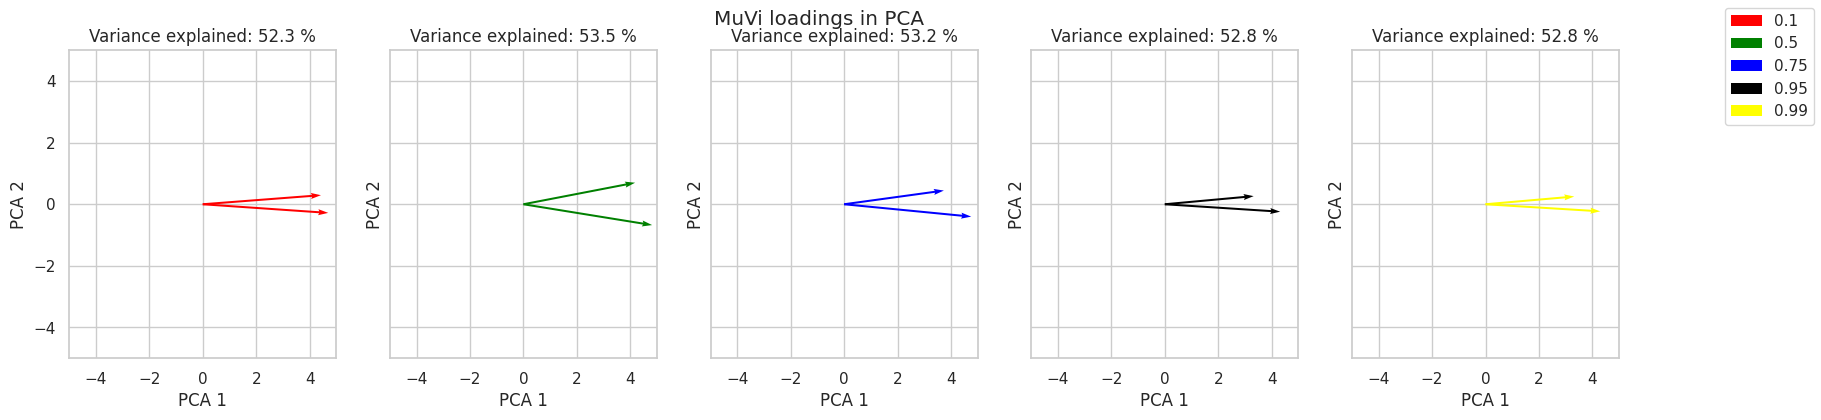

In [51]:
prior_confidence = [0.1,0.5,0.75,0.95,0.99]
fig,ax = plt.subplots(1,len(prior_confidence),figsize=(20,4),sharey=True)
c = ['red','green','blue','black','yellow','purple']
for i,p in enumerate(prior_confidence):
    model = muvi.MuVI(
        observations={"dna": y}, # single view
        # n_factors=n_components,
        device=device,
        prior_confidence=p,
        normalize=False,
        prior_masks={'dna':generate_mask_2_diag(genes)}
    )
    max_iter = 1000
    model.fit(seed=0,n_epochs=max_iter)
    approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and gene j
    approx_ws = np.concatenate(approx_ws, axis=1)
    # project MuVi loadings into PCAs
    muvi_in_pcas = pca.transform(approx_ws)
    ax[i].quiver([0, 0], [0, 0], muvi_in_pcas[:, 0], muvi_in_pcas[:, 1], angles='xy', scale_units='xy', scale=1, label=f'{p}', color = c[i%len(prior_confidence)])
    # # Set limits for better visualization
    ax[i].set_xlim(-5, 5)
    ax[i].set_ylim(-5, 5)
    ax[i].set_xlabel('PCA 1')
    ax[i].set_ylabel('PCA 2')
    r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
    ax[i].set_title(f"Variance explained: {round(100*r2_view['dna'],1)} %")

fig.suptitle('MuVi loadings in PCA')
fig.legend()
plt.show()

**Observation**
1. They don't decouple
2. Variance explained doesn't increase

In [56]:
def generate_mask_2_ones(genes):
    return np.ones(shape=(2,genes))

generate_mask_2_ones(4)

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]])

 38%|███▊      | 376/1000 [00:09<00:15, 39.43it/s, ELBO=145]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.000157 < 1e-05 for 10 step(s) in a row, stopping early.


 38%|███▊      | 376/1000 [00:09<00:16, 38.63it/s, ELBO=145]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.000157 < 1e-05 for 10 step(s) in a row, stopping early.


 38%|███▊      | 376/1000 [00:09<00:15, 39.62it/s, ELBO=145]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.000157 < 1e-05 for 10 step(s) in a row, stopping early.


 38%|███▊      | 376/1000 [00:09<00:15, 39.84it/s, ELBO=145]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.000157 < 1e-05 for 10 step(s) in a row, stopping early.


 38%|███▊      | 376/1000 [00:09<00:15, 40.72it/s, ELBO=145]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.000157 < 1e-05 for 10 step(s) in a row, stopping early.


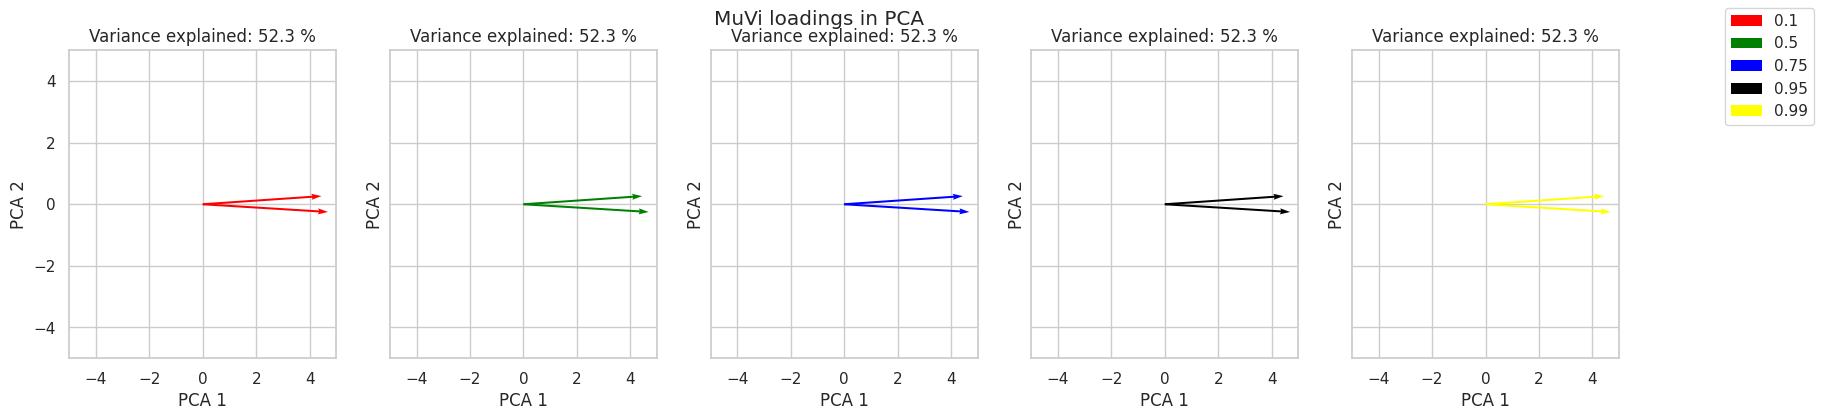

In [58]:
prior_confidence = [0.1,0.5,0.75,0.95,0.99]
fig,ax = plt.subplots(1,len(prior_confidence),figsize=(20,4),sharey=True)
c = ['red','green','blue','black','yellow','purple']
for i,p in enumerate(prior_confidence):
    model = muvi.MuVI(
        observations={"dna": y}, # single view
        n_factors=n_components,
        device=device,
        prior_confidence=p,
        normalize=False,
        prior_masks={'dna':generate_mask_2_ones(genes)}
    )
    max_iter = 1000
    model.fit(seed=0,n_epochs=max_iter)
    approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and gene j
    approx_ws = np.concatenate(approx_ws, axis=1)
    # project MuVi loadings into PCAs
    muvi_in_pcas = pca.transform(approx_ws)
    ax[i].quiver([0, 0], [0, 0], muvi_in_pcas[:, 0], muvi_in_pcas[:, 1], angles='xy', scale_units='xy', scale=1, label=f'{p}', color = c[i%len(prior_confidence)])
    # # Set limits for better visualization
    ax[i].set_xlim(-5, 5)
    ax[i].set_ylim(-5, 5)
    ax[i].set_xlabel('PCA 1')
    ax[i].set_ylabel('PCA 2')
    r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
    ax[i].set_title(f"Variance explained: {round(100*r2_view['dna'],1)} %")

fig.suptitle('MuVi loadings in PCA')
fig.legend()
plt.show()

## De-couple factors via Prior Covariance Matrix of Error $\Psi$
We test two methods:
1. Currently $\Psi = diag(\sigma^{2(m)}), \sigma^2\sim LogNormal(0,1)$. Change to: $\Psi = \sigma^2 I, \sigma^2\sim LogNormal(0,1)$.
    1. In principle (according to Bishop Probabilistic PCA) this should lead to PCA
1. $\Psi = diag(\Psi_i)$, where $\Psi_i\sim$InverseGamma$(\alpha,\beta)$, for large $\alpha,\beta$ could decorrelate $Y|X$
    1. Easier to implement
    1. Converges to $\sigma I$


In [6]:
from MuVI import muvi as muvi_2

 38%|███▊      | 376/1000 [00:09<00:16, 38.13it/s, ELBO=143]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.0005836 < 1e-05 for 10 step(s) in a row, stopping early.


 38%|███▊      | 376/1000 [00:08<00:13, 45.93it/s, ELBO=143]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.0005836 < 1e-05 for 10 step(s) in a row, stopping early.


 38%|███▊      | 376/1000 [00:08<00:13, 45.98it/s, ELBO=143]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.0005836 < 1e-05 for 10 step(s) in a row, stopping early.


 38%|███▊      | 376/1000 [00:08<00:13, 46.08it/s, ELBO=143]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.0005836 < 1e-05 for 10 step(s) in a row, stopping early.


 38%|███▊      | 376/1000 [00:08<00:14, 43.17it/s, ELBO=143]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -0.0005836 < 1e-05 for 10 step(s) in a row, stopping early.


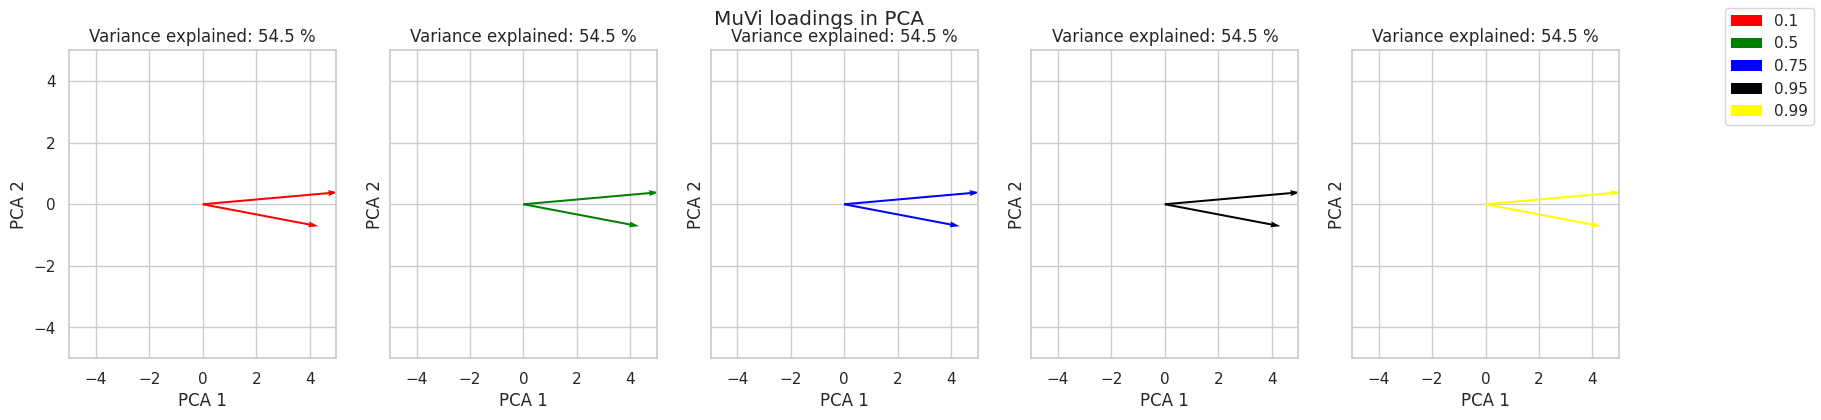

In [10]:
prior_confidence = [0.1,0.5,0.75,0.95,0.99]
fig,ax = plt.subplots(1,len(prior_confidence),figsize=(20,4),sharey=True)
c = ['red','green','blue','black','yellow','purple']
for i,p in enumerate(prior_confidence):
    model = muvi_2.MuVI(
        observations={"dna": y}, # single view
        n_factors=n_components,
        device=device,
        prior_confidence=p,
        normalize=False,
    )
    max_iter = 1000
    model.fit(seed=0,n_epochs=max_iter)
    approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and gene j
    approx_ws = np.concatenate(approx_ws, axis=1)
    # project MuVi loadings into PCAs
    muvi_in_pcas = pca.transform(approx_ws)
    ax[i].quiver([0, 0], [0, 0], muvi_in_pcas[:, 0], muvi_in_pcas[:, 1], angles='xy', scale_units='xy', scale=1, label=f'{p}', color = c[i%len(prior_confidence)])
    # # Set limits for better visualization
    ax[i].set_xlim(-5, 5)
    ax[i].set_ylim(-5, 5)
    ax[i].set_xlabel('PCA 1')
    ax[i].set_ylabel('PCA 2')
    r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
    ax[i].set_title(f"Variance explained: {round(100*r2_view['dna'],1)} %")

fig.suptitle('MuVi loadings in PCA')
fig.legend()
plt.show()

## Three factors

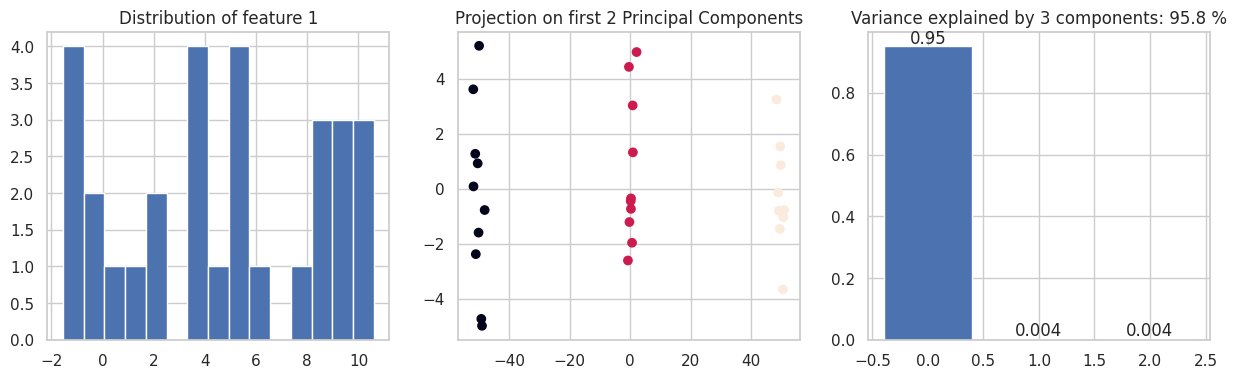

In [212]:
# define tau        
taus = [0,5,10]
# taus = [tau + np.arange(100) for tau in taus] # choose different tau per feature. Shared pattern across treatments
fig,ax = plt.subplots(1,3,figsize=(15,4))
# generate data
y,labels = generate_data(size=(10,100), taus = taus)
# visualize first column of data. Should look like N normals
i = 0
ax[0].hist(y[:,i],bins=15)
ax[0].set_title(f'Distribution of feature {i+1}')
# plt.show()
# compute PCA
n_components = len(taus)
pca = PCA(n_components=n_components)
y_proj = pca.fit_transform(y)
# plot data on first 2 components
ax[1].scatter(y_proj[:,0],y_proj[:,1],c = labels)
ax[1].set_title('Projection on first 2 Principal Components')
# plt.show()
# Compute % of var explained
ax[2].bar(x = np.arange(n_components),height = pca.explained_variance_ratio_)
addlabels(x=np.arange(n_components),y=pca.explained_variance_ratio_)
ax[2].set_title(f'Variance explained by {n_components} components: {round(100*sum(pca.explained_variance_ratio_),1)} %')
plt.show()


In [213]:
model = muvi.MuVI(
    observations={"dna": y}, # single view
    n_factors=n_components,
    device=device,
    prior_confidence='low',
)
max_iter = 1000
model.fit(seed=0,n_epochs=max_iter)
factor_scales = model._guide.get_factor_scale() # delta of factor k
factor_scales = factor_scales / np.max(factor_scales, axis=1)[:, None]
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and gene j
approx_ws = np.concatenate(approx_ws, axis=1)
approx_x = model.get_factor_scores() # factor k in cell i
# model.get_covariate_coefficients() # betas

 50%|█████     | 502/1000 [00:14<00:14, 34.09it/s, ELBO=57]  

Relative improvement of -0.00326 < 1e-05 for 10 step(s) in a row, stopping early.


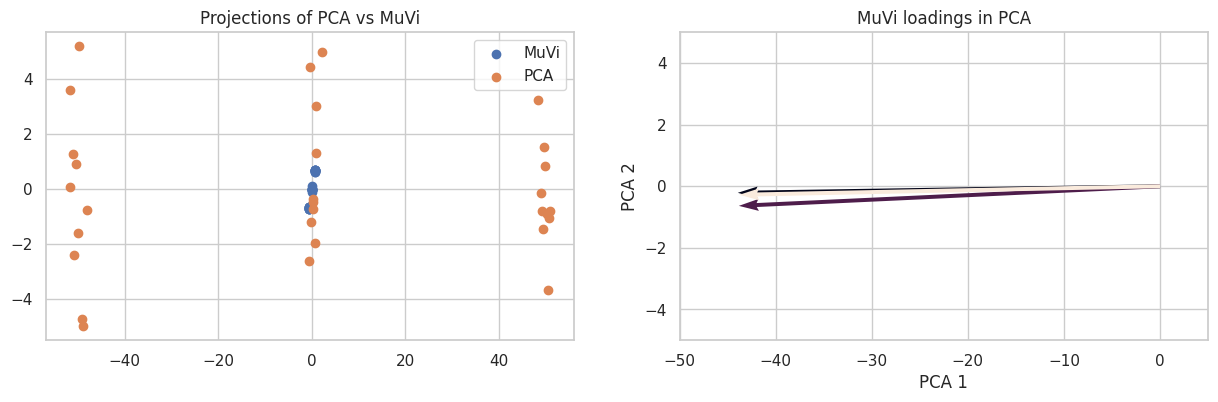

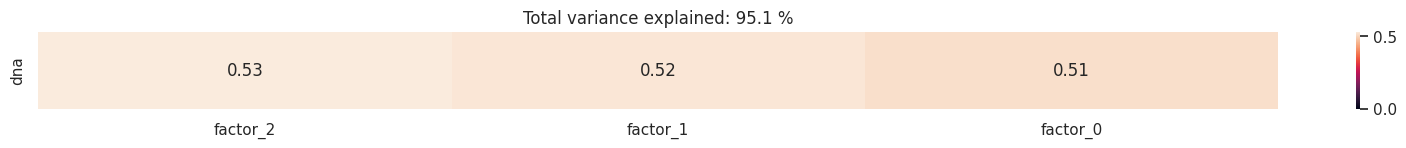

In [217]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].scatter(approx_x[:,0],approx_x[:,1],label='MuVi')
# plot data on first 2 components
ax[0].scatter(y_proj[:,0],y_proj[:,1],label='PCA')
ax[0].legend()
ax[0].set_title('Projections of PCA vs MuVi')

# project MuVi loadings into PCAs
muvi_in_pcas = pca.transform(approx_ws)
ax[1].quiver([0, 0, 0], [0, 0, 0], muvi_in_pcas[:, 0], muvi_in_pcas[:, 1],muvi_in_pcas[:, 2], angles='xy', scale_units='xy', scale=1, color=['r', 'b','g'])
# # Set limits for better visualization
ax[1].set_xlim(-50, 5)
ax[1].set_ylim(-5, 5)
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 2')
ax[1].set_title('MuVi loadings in PCA')

# plot variance explained
r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
g = muvi.pl.variance_explained(model,annot=True,show=False)
plt.title(f"Total variance explained: {round(100*r2_view['dna'],1)} %")
plt.show()

## Two factors with different taus per feature

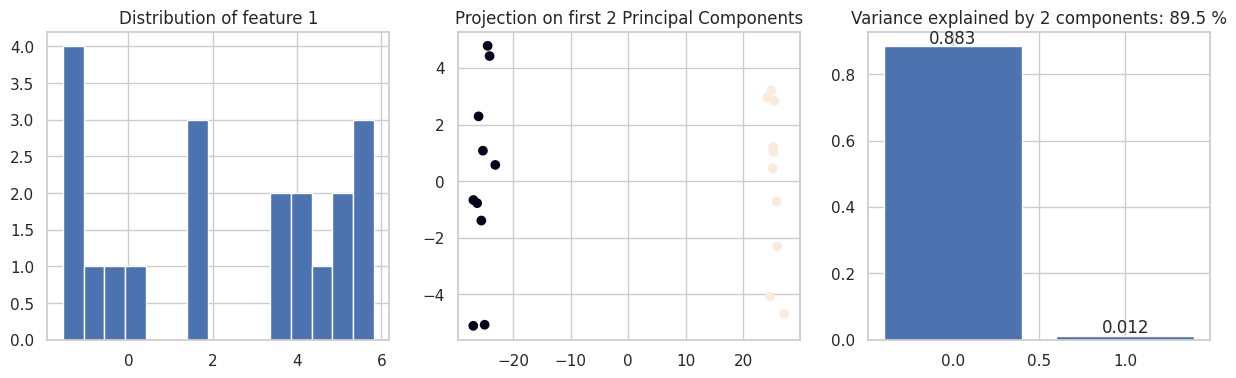

In [218]:
# define tau        
taus = [0,5]
taus = [tau + np.arange(100) for tau in taus] # choose different tau per feature.
fig,ax = plt.subplots(1,3,figsize=(15,4))
# generate data
y,labels = generate_data(size=(10,100), taus = taus)
# visualize first column of data. Should look like N normals
i = 0
ax[0].hist(y[:,i],bins=15)
ax[0].set_title(f'Distribution of feature {i+1}')
# plt.show()
# compute PCA
n_components = len(taus)
pca = PCA(n_components=n_components)
y_proj = pca.fit_transform(y)
# plot data on first 2 components
ax[1].scatter(y_proj[:,0],y_proj[:,1],c = labels)
ax[1].set_title('Projection on first 2 Principal Components')
# plt.show()
# Compute % of var explained
ax[2].bar(x = np.arange(n_components),height = pca.explained_variance_ratio_)
addlabels(x=np.arange(n_components),y=pca.explained_variance_ratio_)
ax[2].set_title(f'Variance explained by {n_components} components: {round(100*sum(pca.explained_variance_ratio_),1)} %')
plt.show()


In [219]:
model = muvi.MuVI(
    observations={"dna": y}, # single view
    n_factors=n_components,
    device=device,
    prior_confidence='low',
)
max_iter = 1000
model.fit(seed=0,n_epochs=max_iter)
factor_scales = model._guide.get_factor_scale() # delta of factor k
factor_scales = factor_scales / np.max(factor_scales, axis=1)[:, None]
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and gene j
approx_ws = np.concatenate(approx_ws, axis=1)
approx_x = model.get_factor_scores() # factor k in cell i
# model.get_covariate_coefficients() # betas

 36%|███▌      | 360/1000 [00:09<00:16, 39.47it/s, ELBO=96.9]

Relative improvement of -0.001144 < 1e-05 for 10 step(s) in a row, stopping early.


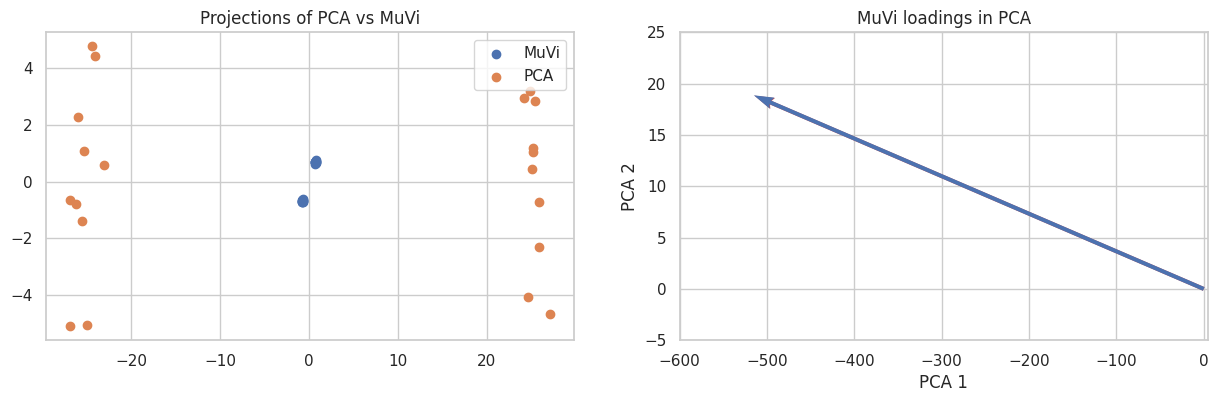

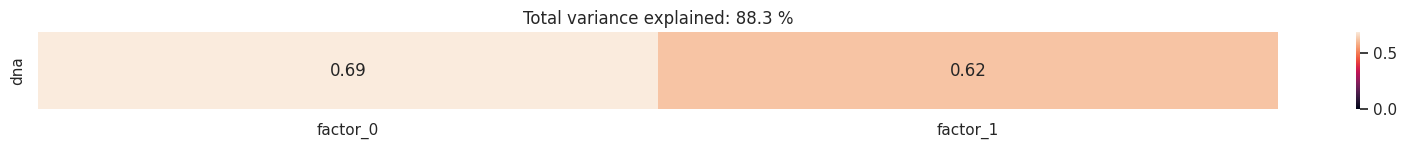

In [227]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].scatter(approx_x[:,0],approx_x[:,1],label='MuVi')
# plot data on first 2 components
ax[0].scatter(y_proj[:,0],y_proj[:,1],label='PCA')
ax[0].legend()
ax[0].set_title('Projections of PCA vs MuVi')

# project MuVi loadings into PCAs
muvi_in_pcas = pca.transform(approx_ws)
ax[1].quiver([0, 0], [0, 0 ], muvi_in_pcas[:, 0], muvi_in_pcas[:, 1], angles='xy', scale_units='xy', scale=1, color=['r', 'b'])
# # Set limits for better visualization
ax[1].set_xlim(-600, 5)
ax[1].set_ylim(-5, 25)
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 2')
ax[1].set_title('MuVi loadings in PCA')

# plot variance explained
r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
g = muvi.pl.variance_explained(model,annot=True,show=False)
plt.title(f"Total variance explained: {round(100*r2_view['dna'],1)} %")
plt.show()

## Two factors with trend across treatment

# Factors with covariates

## Two factors

 42%|████▏     | 420/1000 [00:11<00:15, 37.64it/s, ELBO=104]
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Relative improvement of -9.882e-05 < 1e-05 for 10 step(s) in a row, stopping early.


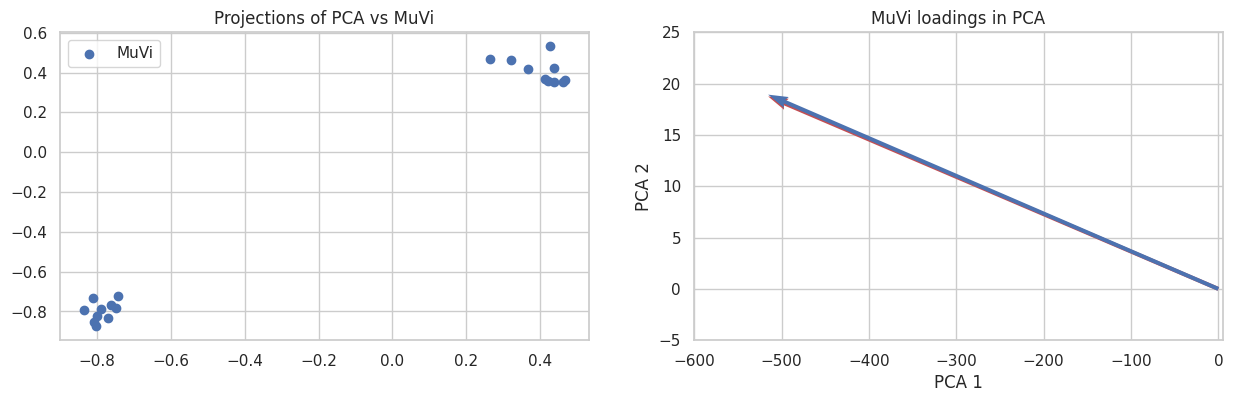

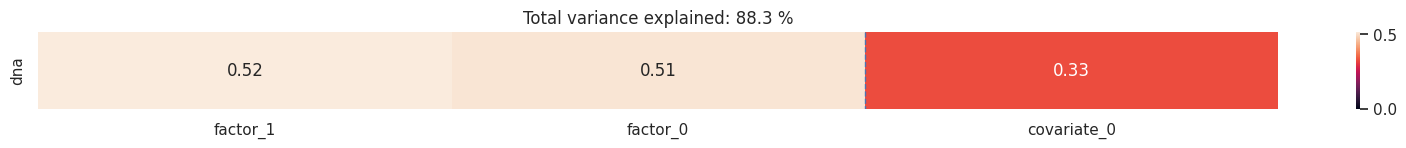

In [229]:
# create two views: [PBS,NonPBS], each size num_genes X num_samples --the num samples differs from view to view
# covariate
x = np.concatenate([np.zeros(shape=(10,1)),np.ones(shape=(10,1))], axis=0)

model = muvi.MuVI(
    observations={"dna": y}, # single view
    n_factors=n_components,
    device=device,
    prior_confidence='low',
    covariates = x
)
max_iter = 1000
model.fit(seed=0,n_epochs=max_iter)
factor_scales = model._guide.get_factor_scale() # delta of factor k
factor_scales = factor_scales / np.max(factor_scales, axis=1)[:, None]
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and gene j
approx_ws = np.concatenate(approx_ws, axis=1)
approx_x = model.get_factor_scores() # factor k in cell i
# model.get_covariate_coefficients() # betas

fig,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].scatter(approx_x[:,0],approx_x[:,1],label='MuVi')
# plot data on first 2 components
# ax[0].scatter(y_proj[:,0],y_proj[:,1],label='PCA')
ax[0].legend()
ax[0].set_title('Projections of PCA vs MuVi')

# project MuVi loadings into PCAs
muvi_in_pcas = pca.transform(approx_ws)
ax[1].quiver([0, 0], [0, 0 ], muvi_in_pcas[:, 0], muvi_in_pcas[:, 1], angles='xy', scale_units='xy', scale=1, color=['r', 'b'])
# # Set limits for better visualization
ax[1].set_xlim(-600, 5)
ax[1].set_ylim(-5, 25)
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 2')
ax[1].set_title('MuVi loadings in PCA')

# plot variance explained
r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
g = muvi.pl.variance_explained(model,annot=True,show=False)
plt.title(f"Total variance explained: {round(100*r2_view['dna'],1)} %")
plt.show()

# Three factors

2024-11-01 13:59:15,505 - muvi.core.models - WARNING - No view names provided!
2024-11-01 13:59:15,506 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-11-01 13:59:15,507 - muvi.core.models - WARNING - Running MuVI on a single view.
2024-11-01 13:59:15,508 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-11-01 13:59:15,509 - muvi.core.models - INFO - Setting the name of each feature in `dna` to `dna_feature_idx`.
2024-11-01 13:59:15,510 - muvi.core.models - INFO - np.ndarray detected.
2024-11-01 13:59:15,510 - muvi.core.models - INFO - Likelihoods set to `{'dna': 'normal'}`.
2024-11-01 13:59:15,511 - muvi.core.models - INFO - NMF set to `{'dna': False}`.
2024-11-01 13:59:15,511 - muvi.core.models - INFO - Normalizing observations.
2024-11-01 13:59:15,512 - muvi.core.models - INFO - Centering features of view `dna`.
2024-11-01 13:59:15,513 - muvi.core.models - INFO - Setting global standard dev

  0%|          | 0/1000 [00:00<?, ?it/s]

2024-11-01 13:59:15,575 - root - INFO - Guessed max_plate_nesting = 3


 47%|████▋     | 468/1000 [00:10<00:11, 46.60it/s, ELBO=186]

Relative improvement of -0.0005909 < 1e-05 for 10 step(s) in a row, stopping early.
2024-11-01 13:59:25,592 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


2024-11-01 13:59:25,988 - muvi.core.models - WARNING - No view names provided!
2024-11-01 13:59:25,988 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-11-01 13:59:25,989 - muvi.core.models - WARNING - Running MuVI on a single view.
2024-11-01 13:59:25,990 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-11-01 13:59:25,991 - muvi.core.models - INFO - Setting the name of each feature in `dna` to `dna_feature_idx`.
2024-11-01 13:59:25,992 - muvi.core.models - INFO - np.ndarray detected.
2024-11-01 13:59:25,993 - muvi.core.models - INFO - Likelihoods set to `{'dna': 'normal'}`.
2024-11-01 13:59:25,994 - muvi.core.models - INFO - NMF set to `{'dna': False}`.
2024-11-01 13:59:25,994 - muvi.core.models - INFO - Normalizing observations.
2024-11-01 13:59:25,995 - muvi.core.models - INFO - Centering features of view `dna`.
2024-11-01 13:59:25,996 - muvi.core.models - INFO - Setting global standard dev

  0%|          | 0/1000 [00:00<?, ?it/s]

2024-11-01 13:59:26,023 - root - INFO - Guessed max_plate_nesting = 3


 53%|█████▎    | 532/1000 [00:11<00:09, 46.86it/s, ELBO=115]

Relative improvement of -0.0009244 < 1e-05 for 10 step(s) in a row, stopping early.
2024-11-01 13:59:37,364 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


2024-11-01 13:59:37,723 - muvi.core.models - WARNING - No view names provided!
2024-11-01 13:59:37,723 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-11-01 13:59:37,724 - muvi.core.models - WARNING - Running MuVI on a single view.
2024-11-01 13:59:37,725 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-11-01 13:59:37,726 - muvi.core.models - INFO - Setting the name of each feature in `dna` to `dna_feature_idx`.
2024-11-01 13:59:37,727 - muvi.core.models - INFO - np.ndarray detected.
2024-11-01 13:59:37,728 - muvi.core.models - INFO - Likelihoods set to `{'dna': 'normal'}`.
2024-11-01 13:59:37,728 - muvi.core.models - INFO - NMF set to `{'dna': False}`.
2024-11-01 13:59:37,729 - muvi.core.models - INFO - Normalizing observations.
2024-11-01 13:59:37,730 - muvi.core.models - INFO - Centering features of view `dna`.
2024-11-01 13:59:37,731 - muvi.core.models - INFO - Setting global standard dev

  0%|          | 0/1000 [00:00<?, ?it/s]

2024-11-01 13:59:37,759 - root - INFO - Guessed max_plate_nesting = 3


 57%|█████▋    | 571/1000 [00:12<00:09, 45.82it/s, ELBO=49]  

Relative improvement of -0.002833 < 1e-05 for 10 step(s) in a row, stopping early.
2024-11-01 13:59:50,208 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


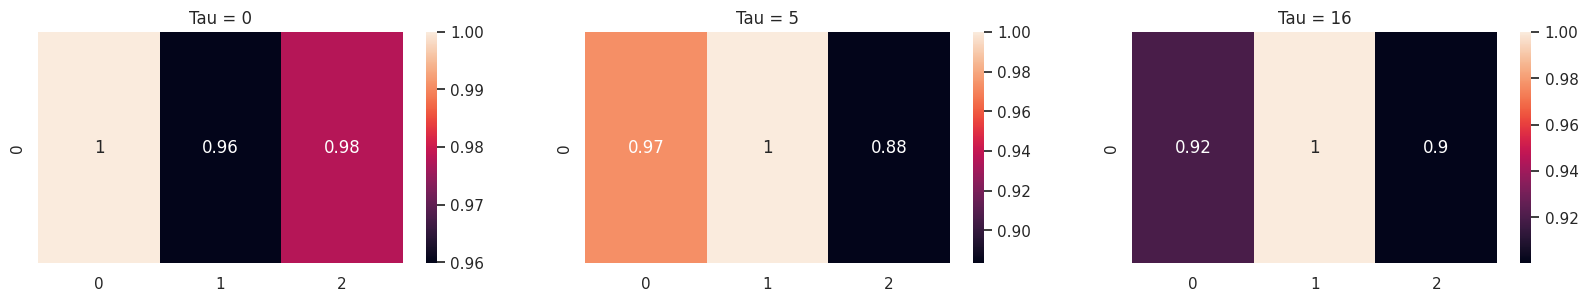

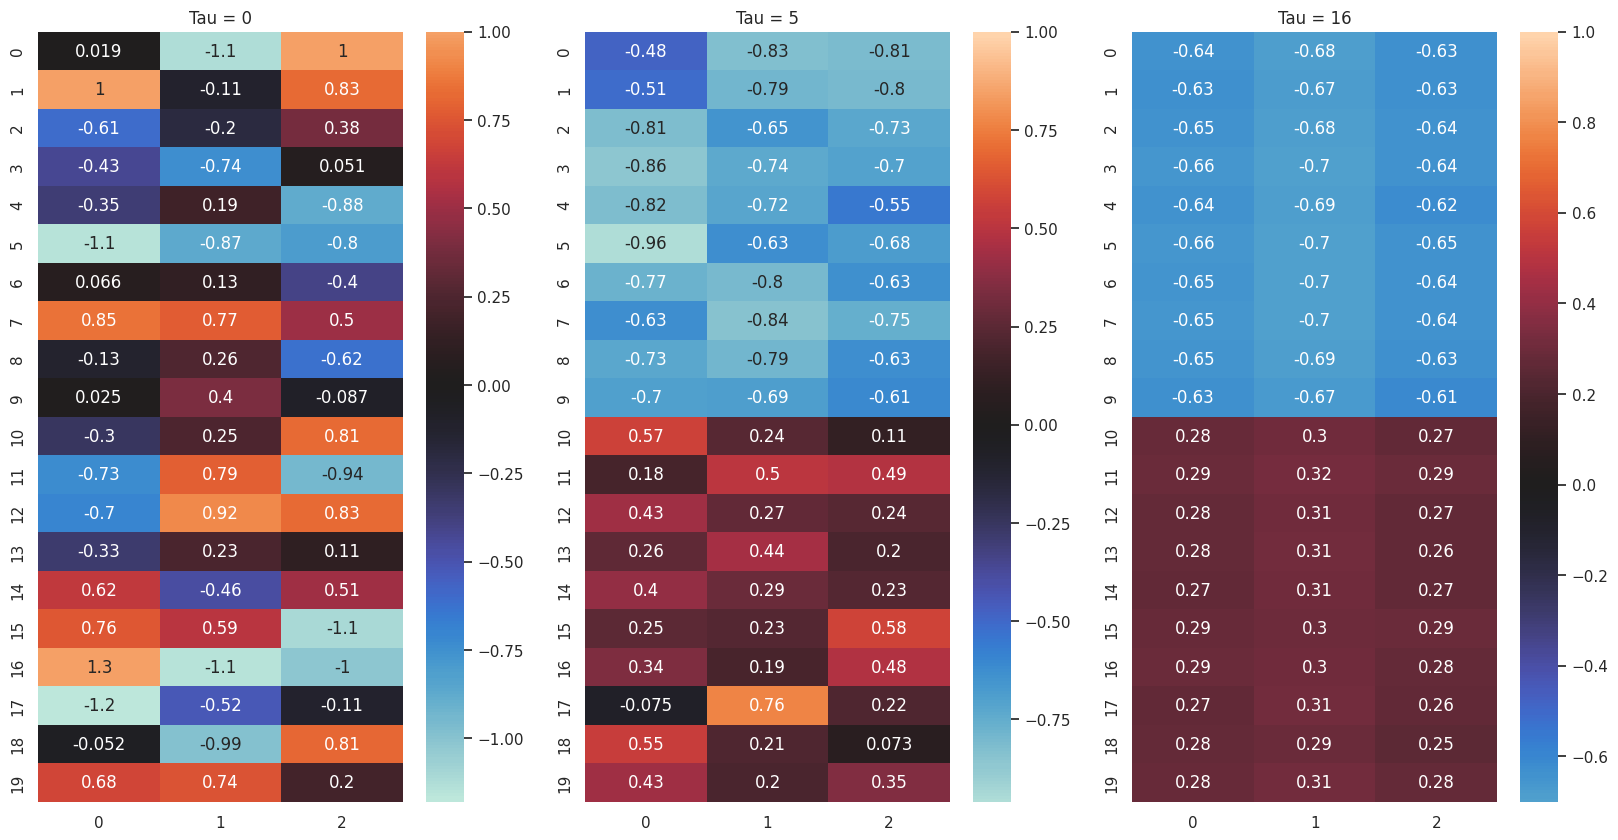

In [42]:
# create two views: [PBS,NonPBS], each size num_genes X num_samples --the num samples differs from view to view
genes = 100
cells = 10 # per group
sigma = 1 # sigma1=sigma2 for now
max_iter = 1000
K = 3 # num factors
factors = []
ws = []
xs = []
taus = [0,5,16]
fig, ax = plt.subplots(1,len(taus),figsize = (20,3))
fig1, ax1 = plt.subplots(1,len(taus),figsize = (20,10))

for i,tau in enumerate(taus):
    # normals
    y_control = np.random.normal(loc=0,scale=sigma,size=(cells,genes))
    y_treat = np.random.normal(loc=tau,scale=sigma,size=(cells,genes))
    y = np.concatenate([y_control,y_treat],axis = 0)
    # covariate
    x = np.concatenate([np.zeros(shape=(cells,1)),np.ones(shape=(cells,1))], axis=0)
    
    model = muvi.MuVI(
        observations={"dna": y}, # single view
        covariates=x,
        n_factors=K,
        device=device,
        prior_confidence='low',
    )
    model.fit(seed=0,n_epochs=max_iter)
    factor_scales = model._guide.get_factor_scale()
    factors.append(factor_scales / np.max(factor_scales, axis=1)[:, None])# delta of factor k
    approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names] # loadings w of factor k and gene j
    ws.append(np.concatenate(approx_ws, axis=1))
    approx_x = model.get_factor_scores() # factor k in cell i
    xs.append(approx_x)
    ax[i].set_title(f'Tau = {taus[i]}')
    sns.heatmap(factors[i],annot=True,vmax= 1.0,ax=ax[i])
    
    ax1[i].set_title(f'Tau = {taus[i]}')
    sns.heatmap(approx_x,annot=True,vmax= 1.0,ax=ax1[i], center=0)
    
plt.show()

## Three factors with trend

In [40]:
1/np.arange(1,cells+1)

array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ])

# EXTRA

In [15]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
    print(device)
except Exception as e:
    print(e)

cuda:0


In [16]:
# load out data. FIRST run data_transformation_r_to_python nb
# Then run this chunk
path = '../spectra_experiments/'
# Load the main data matrix
data = mmread(path+"B_cell_counts.mtx").transpose().tocsr()  # Convert to CSR format which is more efficient for row slicing

# Load metadata
meta_data = pd.read_csv(path+"meta_data.csv", index_col=0)

# Create an AnnData object
adata = ad.AnnData(X=data, obs=meta_data)
print(adata)

AnnData object with n_obs × n_vars = 8086 × 31053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO', 'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito', 'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype', 'channel_hashtag', 'sample', 'rep'


In [54]:
# create two views: [PBS,NonPBS], each size num_genes X num_samples --the num samples differs from view to view
model = muvi.MuVI(
    observations={"pbs": adata[adata.obs['sample']=='PBS'].X[:100].T.todense(), # TODO : remove computing for first 100
                  "nonpbs": adata[adata.obs['sample']!='PBS'].X[:100].T.todense()},
    n_factors=10,
    device=device,
    prior_confidence='low',
)

2024-10-10 23:24:21,104 - muvi.core.models - WARNING - No view names provided!
2024-10-10 23:24:21,105 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-10 23:24:21,206 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-10 23:24:21,219 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-10 23:24:21,220 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-10 23:24:21,240 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`.
2024-10-10 23:24:21,240 - muvi.core.models - INFO - NMF set to `{'nonpbs': False, 'pbs': False}`.
2024-10-10 23:24:21,241 - muvi.core.models - INFO - Normalizing observations.
2024-10-10 23:24:21,242 - muvi.core.models - INFO - Centering features of view `nonpbs`.
2024-10-10 23:24:21,280 - muvi.core.models - INFO - Setting global standard 

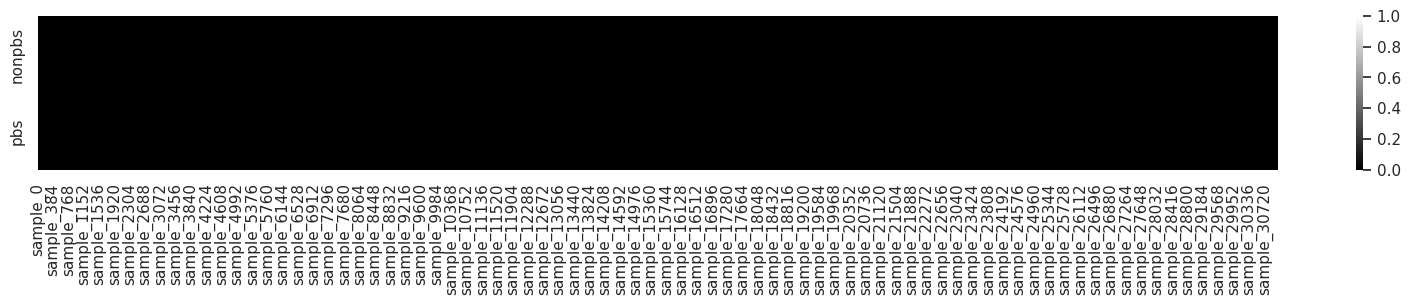

<Axes: >

In [56]:
muvi.pl.missingness_overview(model) # no variables are missing

In [58]:
model.fit(seed=0,n_epochs=10)

2024-10-10 23:25:56,174 - muvi.core.models - INFO - Preparing model and guide...
2024-10-10 23:25:56,175 - muvi.core.models - WARNING - No prior feature sets provided, running model uninformed.
2024-10-10 23:25:56,192 - muvi.core.models - INFO - Preparing optimizer...
2024-10-10 23:25:56,193 - muvi.core.models - INFO - Decaying learning rate over 10 iterations.
2024-10-10 23:25:56,193 - muvi.core.models - INFO - Preparing SVI...
2024-10-10 23:25:56,194 - muvi.core.models - INFO - Preparing training data...
2024-10-10 23:25:56,239 - muvi.core.models - INFO - Using complete dataset.
2024-10-10 23:25:56,250 - muvi.core.models - INFO - Setting training seed to `0`.
2024-10-10 23:25:56,282 - muvi.core.models - INFO - Cleaning parameter store.
2024-10-10 23:25:56,284 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10 [00:00<?, ?it/s]

2024-10-10 23:25:56,321 - root - INFO - Guessed max_plate_nesting = 2


100%|██████████| 10/10 [00:00<00:00, 15.77it/s, ELBO=296]

2024-10-10 23:25:56,922 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


<Axes: >

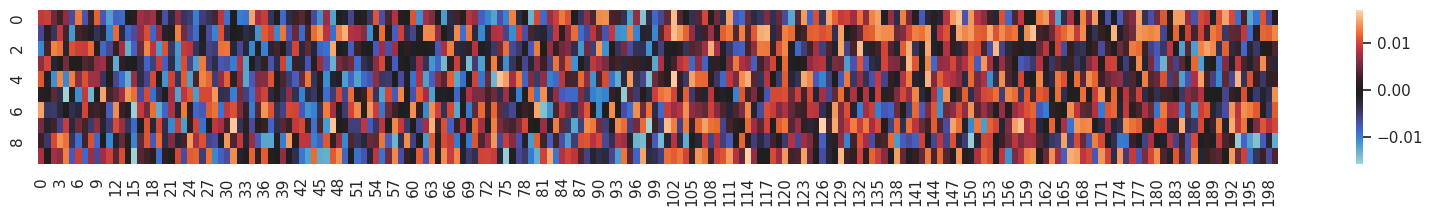

In [59]:
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names]
approx_w = np.concatenate(approx_ws, axis=1)
muvi.pl.lined_heatmap(approx_w, center=0)

Let's produce a mask as follows num_factors x num_samples:
1. first L rows / factors will be common to both; 
2. next L will be private to PBS
3. next L will be private to Non-PBS

We'll have no partially shared factors

In [18]:
# create two views: [PBS,NonPBS], each size num_genes X num_samples --the num samples differs from view to view
model = muvi.MuVI(
    observations={"pbs": adata[adata.obs['sample']=='PBS'].X[:100].T.todense(), # TODO : remove computing for first 100
                  "nonpbs": adata[adata.obs['sample']!='PBS'].X[:100].T.todense()},
    prior_masks=generate_mask(K=30, # divisible by 3
              c1=100, # num_samples PBS
              c2=100), # num_samples Non PBS,
    device=device,
    prior_confidence='high',
)

2024-10-11 14:58:27,865 - muvi.core.models - WARNING - No view names provided!
2024-10-11 14:58:27,866 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-10-11 14:58:27,967 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2024-10-11 14:58:27,980 - muvi.core.models - INFO - Setting the name of each feature in `nonpbs` to `nonpbs_feature_idx`.
2024-10-11 14:58:27,982 - muvi.core.models - INFO - Setting the name of each feature in `pbs` to `pbs_feature_idx`.
2024-10-11 14:58:28,003 - muvi.core.models - INFO - np.ndarray detected.
2024-10-11 14:58:28,004 - muvi.core.models - INFO - np.ndarray detected.
2024-10-11 14:58:28,005 - muvi.core.models - INFO - Likelihoods set to `{'nonpbs': 'normal', 'pbs': 'normal'}`.
2024-10-11 14:58:28,006 - muvi.core.models - INFO - NMF set to `{'nonpbs': False, 'pbs': False}`.
2024-10-11 14:58:28,007 - muvi.core.models - INFO - Normalizing observations.
2024-10-11 14:58:28

In [19]:
model.fit(seed=0,n_epochs=10000)

2024-10-11 14:58:29,083 - muvi.core.models - INFO - Preparing model and guide...
2024-10-11 14:58:29,104 - muvi.core.models - INFO - Preparing optimizer...
2024-10-11 14:58:29,105 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2024-10-11 14:58:29,106 - muvi.core.models - INFO - Preparing SVI...
2024-10-11 14:58:29,108 - muvi.core.models - INFO - Preparing training data...
2024-10-11 14:58:29,156 - muvi.core.models - INFO - Using complete dataset.
2024-10-11 14:58:29,168 - muvi.core.models - INFO - Setting training seed to `0`.
2024-10-11 14:58:29,175 - muvi.core.models - INFO - Cleaning parameter store.
2024-10-11 14:58:29,175 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-11 14:58:29,210 - root - INFO - Guessed max_plate_nesting = 2


 16%|█▌        | 1596/10000 [00:59<05:15, 26.66it/s, ELBO=-30]   

Relative improvement of -0.006823 < 1e-05 for 10 step(s) in a row, stopping early.
2024-10-11 14:59:29,038 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


<Axes: >

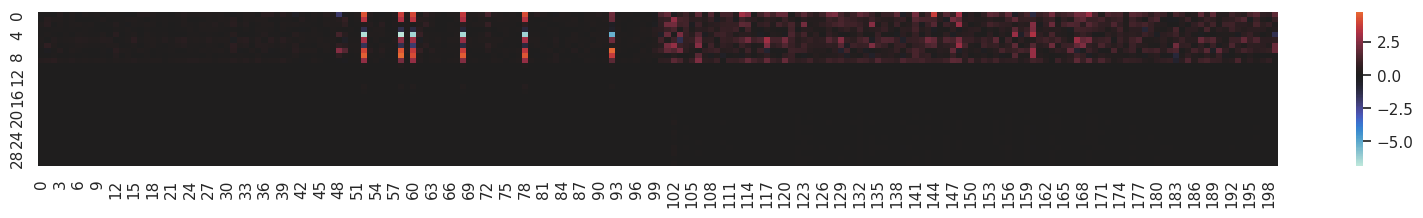

In [20]:
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names]
approx_w = np.concatenate(approx_ws, axis=1)
muvi.pl.lined_heatmap(approx_w, center=0)

In [1]:
model

NameError: name 'model' is not defined

In [21]:
# overall RMSE
root_mean_squared_error(
        np.concatenate(list(model.get_observations(as_df=False).values()),axis=1),
    np.concatenate([model.get_reconstructed()[vn] for vn in model.view_names], 1),
)


0.29309342887212336

In [22]:
from matplotlib import pyplot as plt

(array([ 1.,  1.,  1.,  4.,  6.,  9.,  9., 26., 26., 17.]),
 array([-0.24411904, -0.22412851, -0.20413799, -0.18414746, -0.16415693,
        -0.14416641, -0.12417588, -0.10418535, -0.08419483, -0.0642043 ,
        -0.04421377]),
 <BarContainer object of 10 artists>)

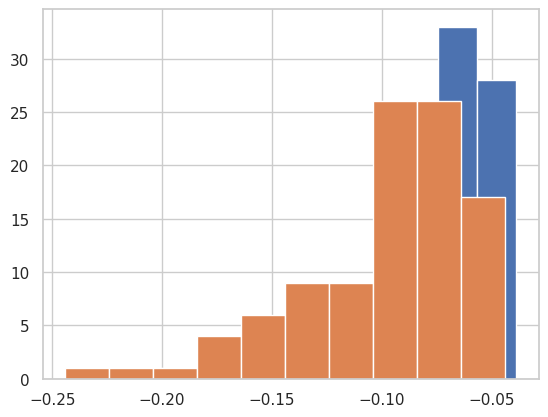

In [25]:
plt.hist(model.get_observations(as_df=False)['pbs'][1])
plt.hist(model.get_reconstructed()['pbs'][1])